In [49]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (train_test_split, cross_val_score, 
                                     GridSearchCV, RandomizedSearchCV)
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
raw_df = pd.read_csv('stats.csv')

In [3]:
df = raw_df.copy()
df.drop('last_name, first_name',axis = 1,inplace=True)
df.drop('player_id',axis = 1,inplace=True)

In [4]:
#new dataset for classification
c_df = df.copy()

# Define the OPS ranges and corresponding classifications
ops_ranges = {
    1: (0.7000, float('inf')),
    0: (-float('inf'), 0.6999)
}

# Create an empty list to store the classifications
classifications = []

for ops_value in c_df['on_base_plus_slg']:
    for classification, (lower_bound, upper_bound) in ops_ranges.items():
        if lower_bound <= ops_value < upper_bound:
            classifications.append(classification)
            break
    else:
        # If the OPS value didn't fall within any range, append a default value
        classifications.append('Unknown')

# Add the classifications to your dataset as a new column
c_df['Classification'] = classifications



#double checking that there are no missing or duplicated values for saftey 

if c_df.isna().any().any():
    print("There are missing values in the classification dataframe c_df.")
else:
    print("There are no missing values in the classification dataframe c_df")

if c_df.duplicated().any().any():
    print("There are duplicated values in the classification dataframe c_df.")
else:
    print("There are no duplicated values in the classification dataframe c_df")

c_df.head(n=5)

There are no missing values in the classification dataframe c_df
There are no duplicated values in the classification dataframe c_df


,year,pa,hit,single,double,triple,home_run,k_percent,bb_percent,on_base_plus_slg,...,barrel_batted_rate,solidcontact_percent,hard_hit_percent,avg_best_speed,avg_hyper_speed,whiff_percent,swing_percent,groundballs_percent,flyballs_percent,Classification
0,2020,231,51,37,4,0,10,22.1,10.4,0.746,...,9.7,5.8,49.7,102.655113,96.026886,31.6,47.7,42.6,21.9,1
1,2020,214,56,34,6,0,16,27.1,11.7,0.992,...,15.0,3.9,47.2,102.723680,95.933078,34.2,47.6,47.2,21.3,1
2,2020,218,61,45,10,1,5,20.6,6.0,0.772,...,5.0,6.3,36.3,100.556637,94.354591,21.1,46.6,51.2,18.8,1
3,2020,209,49,31,10,1,7,18.7,5.3,0.722,...,11.5,3.8,45.2,101.530260,95.520896,21.0,45.0,50.3,25.5,1
4,2020,213,46,26,9,3,8,18.8,8.9,0.752,...,6.5,8.4,38.3,97.982869,93.323023,20.5,46.1,45.5,26.6,1


In [40]:
#train test split datasets

c_train_df = c_df[(c_df['year'] == 2021) | (c_df['year'] == 2020)]
c_val_df = c_df[c_df.year==2022]
c_test_df = c_df[c_df.year==2023]


Base Full model 
StandardScaler
RandomOverSampleer

In [41]:
features = ['k_percent','exit_velocity_avg','sweet_spot_percent', 'barrel_batted_rate','solidcontact_percent', 'hard_hit_percent', 
          'avg_best_speed','avg_hyper_speed',
          'whiff_percent', 'swing_percent',
          'groundballs_percent', 'flyballs_percent']

X_train = c_train_df[features]
y_train = c_train_df.Classification
print(f'The distribution of class obersvations in the training set are: {Counter(y_train)}.')


The distribution of class obersvations in the training set are: Counter({1: 235, 0: 39}).


In [42]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # do scaling


In [43]:
ros = RandomOverSampler(random_state=0)

# Resample the dataset
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
Counter(y_train_resampled)

Counter({1: 235, 0: 235})

Base Model

In [44]:
from sklearn.linear_model import LogisticRegression
#Fit the LogiticRegression model to the trianing data
clf = LogisticRegression()
clf.fit(X_train_resampled, y_train_resampled)
print(f'The accuracy on the scaled, resampled training data is: {clf.score(X_train_resampled,y_train_resampled):.3}.')



X_val = c_val_df[features]
X_val = scaler.transform(X_val)
y_true_val = c_val_df.Classification

#Make predictions on validation data
y_hat_val = clf.predict(X_val)

# Evaluate performance 
accuracy = accuracy_score(y_true_val, y_hat_val)
precision = precision_score(y_true_val, y_hat_val, average='weighted')
print(f'BASE FULL MODEL: \n training score accuracy: {clf.score(X_train_resampled,y_train_resampled):.3} \n validation accuracy: {accuracy:.3} \n validation precision: {precision:.3}.')


The accuracy on the scaled, resampled training data is: 0.779.
BASE FULL MODEL: 
 training score accuracy: 0.779 
 validation accuracy: 0.792 
 validation precision: 0.837.


Grid Search

In [39]:
# parameters = [{'max_iter': [1000, 5000, 10000], 'C': [0.01, 1, 10, 1000], 'penalty': ['l2']}]
# model = linear_model.LogisticRegression(multi_class='multinomial')
# clf = GridSearchCV(model, parameters)
# clf.fit(X_train_resampled, y_train_resampled)

# print(f'clf.best_score_={clf.best_score_:.3}, ' +
#       f'clf.best_params_={clf.best_params_}')

Evaluate Grid Search Model

In [38]:
# model = linear_model.LogisticRegression(multi_class = 'multinomial',C=1000,max_iter=1000,penalty='l2')
# model.fit(X_train_resampled, y_train_resampled)
# model.score(X_train_resampled, y_train_resampled)

# print(f'The accuracy of the Grid Search Model on training data is: {model.score(X_train_resampled,y_train_resampled):.3}.')

# #defining X_val and y_val 
# X_val = c_val_df[features]
# X_val = scaler.transform(X_val)
# y_true_val = c_val_df.Classification

# # Make predictions on validation data
# y_hat_val = model.predict(X_val)

# # Evaluate accuracy
# accuracy = accuracy_score(y_true_val, y_hat_val)

# # Evaluate precision
# precision = precision_score(y_true_val, y_hat_val, average='weighted')
# print(f'accuracy: {accuracy:.3}, precision: {precision:.3}.')


Feature Permutation

In [37]:
# import matplotlib.pyplot as plt
# from sklearn import linear_model
# from sklearn.inspection import permutation_importance
# features = ['k_percent','exit_velocity_avg','sweet_spot_percent', 'barrel_batted_rate','solidcontact_percent', 'hard_hit_percent', 
#           'avg_best_speed','avg_hyper_speed',
#           'whiff_percent', 'swing_percent',
#           'groundballs_percent', 'flyballs_percent']

# model = linear_model.LogisticRegression(multi_class = 'multinomial',C=1000,max_iter=1000,penalty='l2')
# model.fit(X_train_resampled, y_train_resampled)




# X_val = c_val_df[features]
# size = X_val.columns.size
# columns = X_val.columns

# X_val = scaler.transform(X_val)
# y_true_val = c_val_df.Classification
# r = permutation_importance(model, X_val, y_true_val, random_state = 0)
                      


# # model.fit(X_train, y_train)
# # X_val = c_val_df[features]
# # y_true_val = c_val_df['Classification']
# # pi = permutation_importance(model, X_val, y_true_val, random_state=0)

# plt.figure(figsize=(8, 6))
# plt.bar(x=range(size), height=r.importances_mean, tick_label=columns)
# plt.title('Feature Importance for Logistic Regression (Classification)')
# plt.xlabel('Feature Name')
# plt.ylabel('Reduction in Accuracy on Shuffling Feature')
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.savefig('Feature_importance_LogisticRegression_classification.png')
# plt.show()




In [36]:
# features = ['k_percent', 'barrel_batted_rate', 'hard_hit_percent', 'avg_best_speed','avg_hyper_speed','flyballs_percent']

# X_train = c_train_df[features]
# y_train = c_train_df.Classification

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train) # do scaling

# X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# model = linear_model.LogisticRegression(multi_class = 'multinomial',C=1000,max_iter=1000,penalty='l2')
# model.fit(X_train_resampled, y_train_resampled)

# X_val = c_val_df[features]
# y_true_val = c_val_df.Classification

# X_val = scaler.transform(X_val)

# y_hat_val = model.predict(X_val)


# # Evaluate accuracy
# accuracy = accuracy_score(y_true_val, y_hat_val)

# # Evaluate precision
# precision = precision_score(y_true_val, y_hat_val, average='weighted')

# print(f'Reduced MODEL: \n training score accuracy: {model.score(X_train_resampled,y_train_resampled):.3} \n validation accuracy: {accuracy:.3} \n validation precision: {precision:.3}.')


Testing

In [46]:
len(features)

12

Test accuracy: 0.806, Test precision: 0.885.


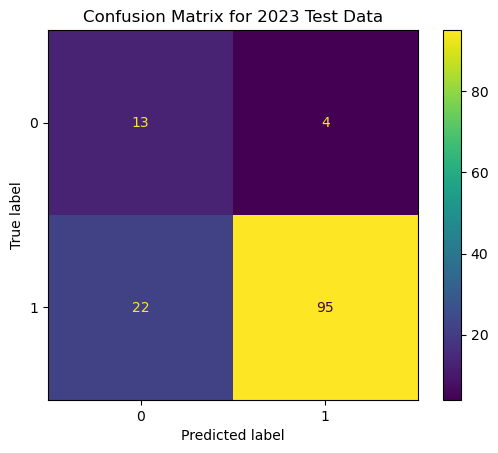

In [61]:
features = ['k_percent','exit_velocity_avg','sweet_spot_percent', 'barrel_batted_rate','solidcontact_percent', 'hard_hit_percent', 
          'avg_best_speed','avg_hyper_speed',
          'whiff_percent', 'swing_percent',
          'groundballs_percent', 'flyballs_percent']

X_test = c_test_df[features]
X_test_scaled = scaler.transform(X_test)
y_true_test = c_test_df['Classification']

clf = LogisticRegression()
clf.fit(X_train_resampled, y_train_resampled)

y_hat_test = clf.predict(X_test_scaled)

test_accuracy = accuracy_score(y_true_test, y_hat_test)
test_precision = precision_score(y_true_test, y_hat_test, average='weighted')

print(f'Test accuracy: {test_accuracy:.3f}, Test precision: {test_precision:.3f}.')

cm = confusion_matrix(y_true_test, y_hat_test, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.title('Confusion Matrix for 2023 Test Data')
plt.savefig('Confusion Matrix For 20203 Test Data.png')
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.76      0.50        17
           1       0.96      0.81      0.88       117

    accuracy                           0.81       134
   macro avg       0.67      0.79      0.69       134
weighted avg       0.88      0.81      0.83       134



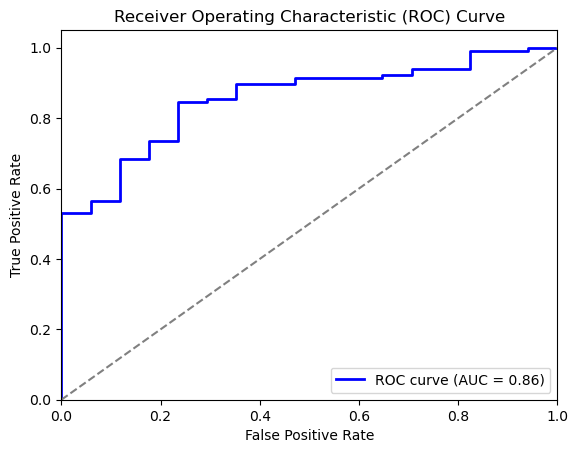

In [92]:
from sklearn.metrics import classification_report, roc_curve, auc

# Classification report
print("Classification Report:")
print(classification_report(y_true_test, y_hat_test))

# ROC curve (if applicable)
if len(clf.classes_) == 2:  # Binary classification
    # Compute ROC curve and AUC for positive class
    fpr, tpr, _ = roc_curve(y_true_test, clf.predict_proba(X_test_scaled)[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.savefig('ROC Curve.png')
    plt.show()


In [91]:
row_data = raw_df.iloc[10:20,].copy()
row_data 
fun = pd.DataFrame(row_data)
fun
features = ['k_percent','exit_velocity_avg','sweet_spot_percent', 'barrel_batted_rate','solidcontact_percent', 'hard_hit_percent', 
          'avg_best_speed','avg_hyper_speed',
          'whiff_percent', 'swing_percent',
          'groundballs_percent', 'flyballs_percent']

x = scaler.transform(fun[features])
clf.predict(x)
print(f'predicted = {clf.predict(x)}.')
# print(f'\nactual =  \n{row_data.on_base_plus_slg}.')

# # fun = fun[features]
# # fun_numeric = fun.apply(pd.to_numeric)


# # X_fun = fun_numeric[xfeatures]

fun['on_base_plus_slg']


# # prediction = model.predict(X_fun)
# # predicted_obps = prediction[0] 


# # actual_obps = fun_numeric['on_base_plus_slg'].iloc[0]

# # print(f'The predicted obps is {predicted_obps:.3} and the actual obps is {actual_obps}.')

predicted = [1 1 0 1 0 1 0 0 1 1].


10    0.840
11    0.658
12    0.605
13    0.680
14    0.694
15    0.883
16    0.606
17    0.630
18    0.763
19    0.769
Name: on_base_plus_slg, dtype: float64